# Cohort Analysis

Foi utilizado o dataset de varejo on-line do UCI Machine Learning Repository. Este é um conjunto de dados de transações que contém todas as transações entre 01/12/2010 e 09/09/2011 para um varejo on-line do Reino Unido.

In [1]:
# Importação de bibliotecas
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importação do dataset
df = pd.read_excel('Online Retail.xlsx')
df.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
123084,546891,85123A,WHITE HANGING HEART T-LIGHT HOLDER,1,2011-03-17 18:18:00,5.79,NaN,United Kingdom
109152,545587,21870,I CAN ONLY PLEASE ONE PERSON MUG,2,2011-03-04 09:46:00,1.25,14796.0,United Kingdom
370127,569129,22086,PAPER CHAIN KIT 50'S CHRISTMAS,3,2011-09-30 13:40:00,2.95,15034.0,United Kingdom


In [3]:
# Verifica o shape dos dados
df.shape

(541909, 8)

Vamos verificar a questão do valores missings. Ao executar o código abaixo, verificamos cerca de 135 mil linhas sem o ID do cliente, portanto, vou descartar todos, pois pode não haver uma maneira lógica de preencher o ID do cliente usando os dados existentes.

In [4]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df1 = df.dropna(subset=['CustomerID'])
df1.shape

(406829, 8)

Agora podemos verificar as informações do dataset limpo. Sobraram cerca de 400 mil linhas, e, a coluna da data da fatura já está no formato de data, portanto, não é necessário realizar mais transformações.

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


## Criação do Cohort

Antes de criar o cohort, preciso reunir duas colunas em relação aos meses: uma é o mês da fatura e a outra é o mês do cohort.

In [7]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

In [8]:
df1['InvoiceMonth'] = df1['InvoiceDate'].apply(get_month)
df1['CohortMonth'] = df1.groupby('CustomerID')['InvoiceMonth'].transform('min')

C:\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


O mês do cohort é o primeiro mês para o ID do usuário.
Por fim, criei um índice de cohort para cada linha, que é a diferença entre o mês da fatura e o mês do cohort para cada linha. Ao fazer a dedução, sou capaz de saber o intervalo de meses entre essa transação específica e a primeira transação que o usuário fez no site.

In [9]:
def get_date(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [10]:
invoice_year, invoice_month, _ = get_date(df1, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date(df1, 'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df1['CohortIndex'] = year_diff * 12 + month_diff + 1

C:\Python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# Cohort Retenção do Usuário

In [11]:
cohort_data = df1.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_count = cohort_data.pivot_table(index = 'CohortMonth',
                                       columns = 'CohortIndex',
                                       values = 'CustomerID')
cohort_count

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A partir do resultado acima, a primeira coluna no gráfico é o número de usuários ativos naquele mês específico e as colunas a seguir mostram quantos usuários ainda estão usando o serviço no segundo, terceiro, quarto mês e etc.
A 13ª coluna e a linha 2010–12–1 significam que 260 dos 948 usuários ainda estavam comprando itens após os 13 meses a partir de 1/12/2010.

Com base nesse dataframe, posso transformar o número absoluto em porcentagem para mostrar a taxa de retenção:

In [12]:
cohort_size = cohort_count.iloc[:,0]
retention = cohort_count.divide(cohort_size, axis = 0)
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,38.2,33.4,38.7,36.0,39.7,38.0,35.4,35.4,39.5,37.3,50.0,27.4
2011-01-01,100.0,24.0,28.3,24.2,32.8,29.9,26.1,25.7,31.1,34.7,36.8,15.0,NaN
2011-02-01,100.0,24.7,19.2,27.9,26.8,24.7,25.5,28.2,25.8,31.3,9.2,NaN,NaN
2011-03-01,100.0,19.1,25.5,21.8,23.2,17.7,26.4,23.9,28.9,8.9,NaN,NaN,NaN
2011-04-01,100.0,22.7,22.1,21.1,20.7,23.7,23.1,26.1,8.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,23.7,17.2,17.2,21.5,24.4,26.5,10.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,20.9,18.7,27.2,24.7,33.6,10.2,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,20.9,20.4,23.0,27.2,11.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,25.1,25.1,25.1,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Por fim, vamos utilizar um mapa de calor para tornar o resultado mais agradável:

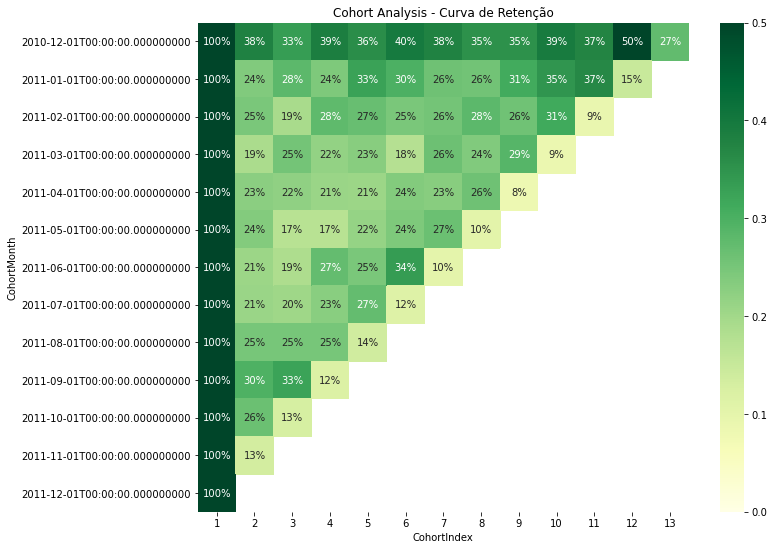

In [13]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Curva de Retenção')
sns.heatmap(data = retention, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "YlGn")
plt.show()

A partir do gráfico, pode-se concluir que em 2011/11 algumas estratégias poderão ser implementadas para aumentar o retorno dos usuários. Cerca de 50% dos usuários do cohort 2010/12 retornam em 2011/11.

# Cohort Média de Produtos Vendidos

Além das métricas de retenção, existem muitas métricas que podemos utilizar no cohort. Nesta 2ª abordagem, utilizamos a média de produtos vendidos por mês, vendo como a quantidade de compra muda com o passar dos meses.

In [14]:
cohort_data2 = df1.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()
average_quantity  = cohort_data2.pivot_table(index = 'CohortMonth',
                                            columns = 'CohortIndex',
                                       values = 'Quantity').round(1)
average_quantity

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.0,14.6,15.0,14.8,12.9,14.3,15.2,14.8,16.7,16.7,17.3,12.8,14.8
2011-01-01,10.0,12.6,12.3,10.9,12.2,14.9,14.2,14.4,11.4,9.9,9.1,9.5,NaN
2011-02-01,10.8,12.1,18.6,12.0,11.1,11.4,13.3,12.4,10.3,11.9,12.6,NaN,NaN
2011-03-01,9.8,9.9,12.2,9.5,13.6,12.3,13.2,12.2,10.5,8.9,NaN,NaN,NaN
2011-04-01,9.8,10.1,9.4,11.6,11.5,8.2,9.7,9.3,7.3,NaN,NaN,NaN,NaN
2011-05-01,10.9,9.0,13.9,11.8,10.9,8.7,10.1,7.4,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.3,13.7,10.5,13.3,10.2,9.8,9.3,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,9.7,12.7,7.1,7.8,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,9.9,6.0,5.3,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


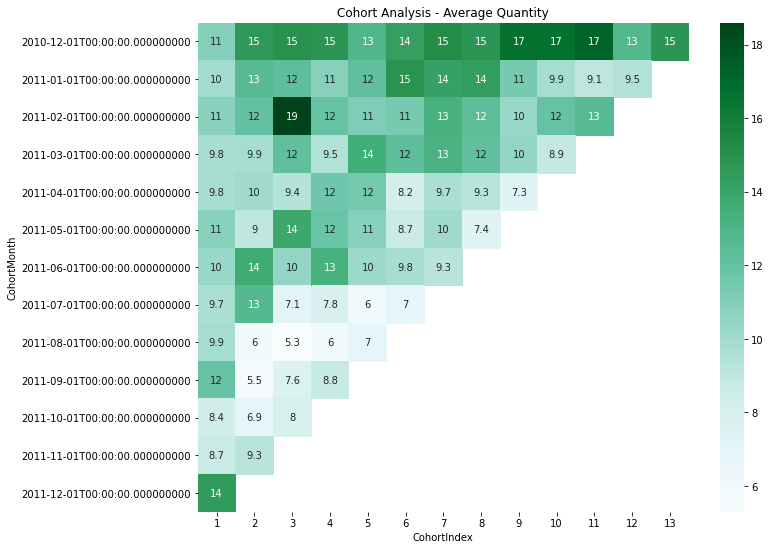

In [15]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Quantity')
sns.heatmap(data = average_quantity, 
            annot = True, 
            cmap = "BuGn")
plt.show()

Observa-se que neste cohort, a quantidade média de vendas estava em declínio. É um sinal de que os usuários param de comprar mercadorias no site. O motivo precisa de mais investigação.

# Cohort Valor Vendido

In [16]:
df1['TotalSale'] = df1['Quantity'] * df1['UnitPrice']
cohort_data3 = df1.groupby(['CohortMonth', 'CohortIndex'])['TotalSale'].mean().reset_index()
average_sales  = cohort_data3.pivot_table(index = 'CohortMonth',
                                           columns = 'CohortIndex',
                                      values = 'TotalSale').round(1)
average_sales

C:\Python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,20.7,25.0,25.1,25.0,19.9,25.5,26.5,25.4,26.0,31.1,30.6,22.2,24.7
2011-01-01,18.4,23.5,20.3,17.5,21.5,25.4,24.4,24.5,18.7,20.1,18.7,18.4,NaN
2011-02-01,17.0,17.0,19.3,18.8,16.1,15.1,21.6,20.9,17.5,20.6,21.5,NaN,NaN
2011-03-01,17.0,17.9,21.5,17.0,19.2,18.1,21.7,17.3,15.4,11.4,NaN,NaN,NaN
2011-04-01,16.4,20.2,18.8,18.4,18.6,14.2,14.6,15.3,11.8,NaN,NaN,NaN,NaN
2011-05-01,19.0,15.7,21.2,19.4,17.8,14.1,16.1,13.3,NaN,NaN,NaN,NaN,NaN
2011-06-01,16.4,14.5,19.0,19.8,15.0,15.9,12.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,13.1,21.2,11.4,12.4,10.5,11.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,16.1,11.9,11.5,14.4,15.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


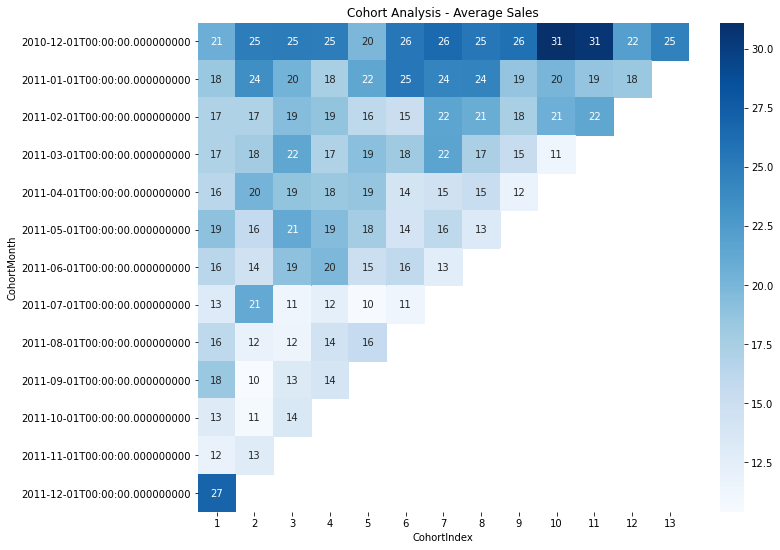

In [17]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Sales')
sns.heatmap(data = average_sales, 
            annot = True, 
            cmap = "Blues")
plt.show()

A situação do valor de vendas vai ao encontro da média de vendas, onde o varejista enfrenta um declínio significativo nos últimos meses.